In [ ]:
!nvidia-smi

Fri Mar  3 05:10:33 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   57C    P0    27W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
from google.colab import drive

drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPool2D, Activation
from tensorflow.keras import Sequential
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras import layers

In [ ]:
# View an image
import os
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import random

def view_random_image(target_dir, target_class):
  # Setup target directory (we'll view images from here)
  target_folder = target_dir+target_class

  # Get a random image path
  random_image = random.sample(os.listdir(target_folder), 1)

  # Read in the image and plot it using matplotlib
  img = mpimg.imread(target_folder + "/" + random_image[0])
  plt.imshow(img)
  plt.title(target_class)
  plt.axis("off");

  print(f"Image shape: {img.shape}") # show the shape of the image

  return img

Image shape: (1304, 1445, 3)


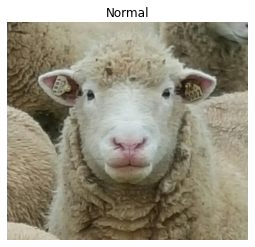

In [ ]:
# View a random image from the training dataset
img = view_random_image(target_dir="/content/drive/MyDrive/SheepData/Train/",
                        target_class="Normal")

In [ ]:
img

array([[[ 73,  65,  44],
        [ 73,  65,  44],
        [ 72,  64,  43],
        ...,
        [169, 170, 172],
        [169, 170, 172],
        [169, 170, 172]],

       [[ 73,  65,  44],
        [ 73,  65,  44],
        [ 72,  64,  43],
        ...,
        [167, 168, 170],
        [167, 168, 170],
        [167, 168, 170]],

       [[ 73,  65,  44],
        [ 73,  65,  44],
        [ 72,  64,  43],
        ...,
        [164, 165, 167],
        [164, 165, 167],
        [164, 165, 167]],

       ...,

       [[188, 178, 151],
        [188, 178, 151],
        [187, 177, 150],
        ...,
        [171, 165, 141],
        [171, 165, 141],
        [172, 166, 142]],

       [[188, 178, 151],
        [188, 178, 151],
        [187, 177, 150],
        ...,
        [171, 165, 141],
        [172, 166, 142],
        [173, 167, 143]],

       [[188, 178, 151],
        [187, 177, 150],
        [187, 177, 150],
        ...,
        [172, 166, 142],
        [173, 167, 143],
        [173, 167, 143]]

In [ ]:
img.shape

(1304, 1445, 3)

In [ ]:
img/225.

array([[[0.32444444, 0.28888889, 0.19555556],
        [0.32444444, 0.28888889, 0.19555556],
        [0.32      , 0.28444444, 0.19111111],
        ...,
        [0.75111111, 0.75555556, 0.76444444],
        [0.75111111, 0.75555556, 0.76444444],
        [0.75111111, 0.75555556, 0.76444444]],

       [[0.32444444, 0.28888889, 0.19555556],
        [0.32444444, 0.28888889, 0.19555556],
        [0.32      , 0.28444444, 0.19111111],
        ...,
        [0.74222222, 0.74666667, 0.75555556],
        [0.74222222, 0.74666667, 0.75555556],
        [0.74222222, 0.74666667, 0.75555556]],

       [[0.32444444, 0.28888889, 0.19555556],
        [0.32444444, 0.28888889, 0.19555556],
        [0.32      , 0.28444444, 0.19111111],
        ...,
        [0.72888889, 0.73333333, 0.74222222],
        [0.72888889, 0.73333333, 0.74222222],
        [0.72888889, 0.73333333, 0.74222222]],

       ...,

       [[0.83555556, 0.79111111, 0.67111111],
        [0.83555556, 0.79111111, 0.67111111],
        [0.83111111, 0

In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Set the seed
tf.random.set_seed(42)

# Preprocess data (get all of the pixel values between 1 and 0, also called scaling/normalization)
train_datagen = ImageDataGenerator(rescale=1./255)
valid_datagen = ImageDataGenerator(rescale=1./255)

# Setup the train and test directories
train_dir = "/content/drive/MyDrive/SheepData/Train/"
test_dir = "/content/drive/MyDrive/SheepData/Test/"

# Import data from directories and turn it into batches
train_data = train_datagen.flow_from_directory(train_dir,
                                               batch_size=32, # number of images to process at a time 
                                               target_size=(224, 224), # convert all images to be 224 x 224
                                               class_mode="binary", # type of problem we're working on
                                               seed=42)

valid_data = valid_datagen.flow_from_directory(test_dir,
                                               batch_size=32,
                                               target_size=(224, 224),
                                               class_mode="binary",
                                               seed=42)

# Create a CNN model (same as Tiny VGG - https://poloclub.github.io/cnn-explainer/)
model_1 = tf.keras.models.Sequential([
  tf.keras.layers.Conv2D(filters=10, 
                         kernel_size=3, # can also be (3, 3)
                         activation="relu", 
                         input_shape=(224, 224, 3)), # first layer specifies input shape (height, width, colour channels)
  tf.keras.layers.Conv2D(10, 3, activation="relu"),
  tf.keras.layers.MaxPool2D(pool_size=2, # pool_size can also be (2, 2)
                            padding="valid"), # padding can also be 'same'
  tf.keras.layers.Conv2D(10, 3, activation="relu"),
  tf.keras.layers.Conv2D(10, 3, activation="relu"), # activation='relu' == tf.keras.layers.Activations(tf.nn.relu)
  tf.keras.layers.MaxPool2D(2),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(1, activation="sigmoid") # binary activation output
])

# Compile the model
model_1.compile(loss="binary_crossentropy",
              optimizer=tf.keras.optimizers.Adam(),
              metrics=["accuracy"])

# Fit the model
history_1 = model_1.fit(train_data,
                        epochs=5,
                        steps_per_epoch=len(train_data),
                        validation_data=valid_data,
                        validation_steps=len(valid_data))


Found 1123 images belonging to 2 classes.
Found 20 images belonging to 2 classes.
Epoch 1/5
36/36 [==============================] - 126s 3s/step - loss: 0.4081 - accuracy: 0.8459 - val_loss: 1.1195 - val_accuracy: 0.5000
Epoch 2/5
36/36 [==============================] - 17s 465ms/step - loss: 0.3510 - accuracy: 0.8718 - val_loss: 0.9436 - val_accuracy: 0.5000
Epoch 3/5
36/36 [==============================] - 17s 473ms/step - loss: 0.3149 - accuracy: 0.8727 - val_loss: 1.0995 - val_accuracy: 0.5000
Epoch 4/5
36/36 [==============================] - 18s 507ms/step - loss: 0.2643 - accuracy: 0.8816 - val_loss: 0.9405 - val_accuracy: 0.5000
Epoch 5/5
36/36 [==============================] - 18s 504ms/step - loss: 0.2102 - accuracy: 0.9181 - val_loss: 0.7885 - val_accuracy: 0.6000


In [ ]:
model_1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 222, 222, 10)      280       
                                                                 
 conv2d_1 (Conv2D)           (None, 220, 220, 10)      910       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 110, 110, 10)     0         
 )                                                               
                                                                 
 conv2d_2 (Conv2D)           (None, 108, 108, 10)      910       
                                                                 
 conv2d_3 (Conv2D)           (None, 106, 106, 10)      910       
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 53, 53, 10)       0         
 2D)                                                    

Image shape: (781, 1024, 3)
Image shape: (654, 1024, 3)


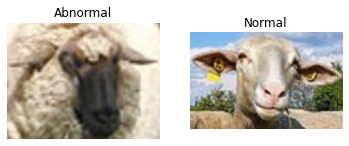

In [ ]:
plt.figure()
plt.subplot(1, 2, 1)
steak_img = view_random_image("/content/drive/MyDrive/SheepData/Train/", "Abnormal")
plt.subplot(1, 2, 2)
pizza_img = view_random_image("/content/drive/MyDrive/SheepData/Train/", "Normal")

In [ ]:
train_dir = "/content/drive/MyDrive/SheepData/Train/"
test_dir = "/content/drive/MyDrive/SheepData/Test/"

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
train_datagen = ImageDataGenerator(rescale=1/255.)
test_datagen = ImageDataGenerator(rescale=1/255.)

In [ ]:
train_data = train_datagen.flow_from_directory(directory=train_dir,
                                               target_size=(224, 224),
                                               class_mode='binary',
                                               batch_size=32)

test_data = test_datagen.flow_from_directory(directory=test_dir,
                                             target_size=(224, 224),
                                             class_mode='binary',
                                             batch_size=32)

Found 1123 images belonging to 2 classes.
Found 20 images belonging to 2 classes.


In [ ]:
images, labels = train_data.next() # get the 'next' batch of images/labels
len(images), len(labels)

(32, 32)

In [ ]:
labels

array([1., 1., 1., 1., 1., 0., 1., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0.],
      dtype=float32)

In [ ]:
model_2 = Sequential([
  Conv2D(filters=10, 
         kernel_size=3, 
         strides=1,
         padding='valid',
         activation='relu', 
         input_shape=(224, 224, 3)), # input layer (specify input shape)
  Conv2D(10, 3, activation='relu'),
  Conv2D(10, 3, activation='relu'),
  Flatten(),
  Dense(1, activation='sigmoid') # output layer (specify output shape)
])
     
model_2.compile(loss='binary_crossentropy',
                optimizer=Adam(),
                metrics=['accuracy'])


history_2 = model_2.fit(train_data,
                        epochs=5,
                        steps_per_epoch=len(train_data),
                        validation_data=test_data,
                        validation_steps=len(test_data))

Epoch 1/5
36/36 [==============================] - 19s 472ms/step - loss: 0.7770 - accuracy: 0.8299 - val_loss: 0.9883 - val_accuracy: 0.5000
Epoch 2/5
36/36 [==============================] - 18s 493ms/step - loss: 0.3396 - accuracy: 0.8700 - val_loss: 0.9469 - val_accuracy: 0.5000
Epoch 3/5
36/36 [==============================] - 17s 473ms/step - loss: 0.2501 - accuracy: 0.9029 - val_loss: 0.9683 - val_accuracy: 0.5000
Epoch 4/5
36/36 [==============================] - 17s 467ms/step - loss: 0.1796 - accuracy: 0.9314 - val_loss: 0.4946 - val_accuracy: 0.7000
Epoch 5/5
36/36 [==============================] - 18s 496ms/step - loss: 0.0915 - accuracy: 0.9662 - val_loss: 0.4674 - val_accuracy: 0.7500


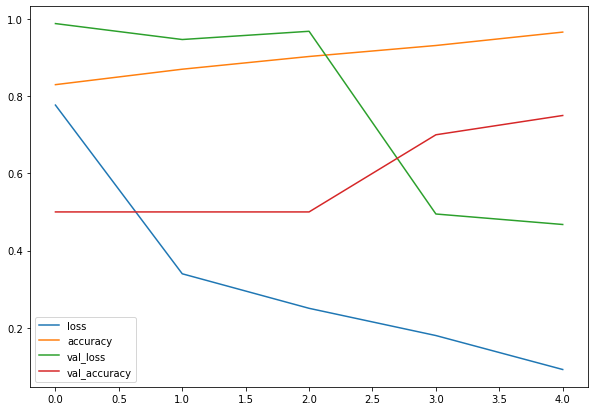

In [ ]:
import pandas as pd
pd.DataFrame(history_2.history).plot(figsize=(10, 7));

In [ ]:
# Plot the validation and training data separately
def plot_loss_curves(history):
  """
  Returns separate loss curves for training and validation metrics.
  """ 
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  accuracy = history.history['accuracy']
  val_accuracy = history.history['val_accuracy']

  epochs = range(len(history.history['loss']))

  # Plot loss
  plt.plot(epochs, loss, label='training_loss')
  plt.plot(epochs, val_loss, label='val_loss')
  plt.title('Loss')
  plt.xlabel('Epochs')
  plt.legend()

  # Plot accuracy
  plt.figure()
  plt.plot(epochs, accuracy, label='training_accuracy')
  plt.plot(epochs, val_accuracy, label='val_accuracy')
  plt.title('Accuracy')
  plt.xlabel('Epochs')
  plt.legend();

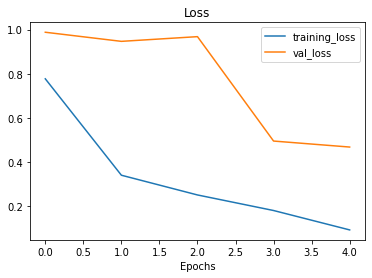

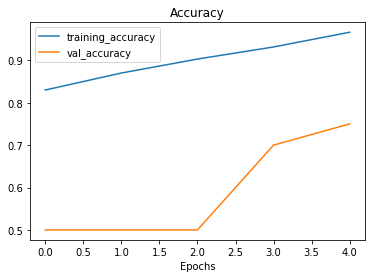

In [ ]:
plot_loss_curves(history_2)

In [ ]:
model_2.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 222, 222, 10)      280       
                                                                 
 conv2d_5 (Conv2D)           (None, 220, 220, 10)      910       
                                                                 
 conv2d_6 (Conv2D)           (None, 218, 218, 10)      910       
                                                                 
 flatten_1 (Flatten)         (None, 475240)            0         
                                                                 
 dense_1 (Dense)             (None, 1)                 475241    
                                                                 
Total params: 477,341
Trainable params: 477,341
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# Create ImageDataGenerator training instance with data augmentation
train_datagen_augmented = ImageDataGenerator(rescale=1/255.,
                                             rotation_range=20, # rotate the image slightly between 0 and 20 degrees (note: this is an int not a float)
                                             shear_range=0.2, # shear the image
                                             zoom_range=0.2, # zoom into the image
                                             width_shift_range=0.2, # shift the image width ways
                                             height_shift_range=0.2, # shift the image height ways
                                             horizontal_flip=True) # flip the image on the horizontal axis

# Create ImageDataGenerator training instance without data augmentation
train_datagen = ImageDataGenerator(rescale=1/255.) 

# Create ImageDataGenerator test instance without data augmentation
test_datagen = ImageDataGenerator(rescale=1/255.)

In [ ]:

# Import data and augment it from training directory
print("Augmented training images:")
train_data_augmented = train_datagen_augmented.flow_from_directory(train_dir,
                                                                   target_size=(224, 224),
                                                                   batch_size=32,
                                                                   class_mode='binary',
                                                                   shuffle=False) # Don't shuffle for demonstration purposes, usually a good thing to shuffle

# Create non-augmented data batches
print("Non-augmented training images:")
train_data = train_datagen.flow_from_directory(train_dir,
                                               target_size=(224, 224),
                                               batch_size=32,
                                               class_mode='binary',
                                               shuffle=False) # Don't shuffle for demonstration purposes

print("Unchanged test images:")
test_data = test_datagen.flow_from_directory(test_dir,
                                             target_size=(224, 224),
                                             batch_size=32,
                                             class_mode='binary')

Augmented training images:
Found 1123 images belonging to 2 classes.
Non-augmented training images:
Found 1123 images belonging to 2 classes.
Unchanged test images:
Found 20 images belonging to 2 classes.


In [ ]:
images, labels = train_data.next()
augmented_images, augmented_labels = train_data_augmented.next() # Note: labels aren't augmented, they stay the same

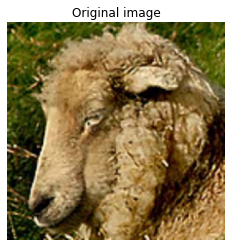

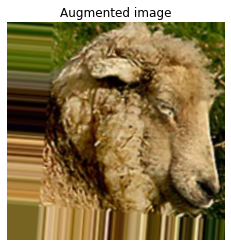

In [ ]:

# Show original image and augmented image
random_number = random.randint(0, 32) # we're making batches of size 32, so we'll get a random instance
plt.imshow(images[random_number])
plt.title(f"Original image")
plt.axis(False)
plt.figure()
plt.imshow(augmented_images[random_number])
plt.title(f"Augmented image")
plt.axis(False);

In [ ]:
# Create the model (same as model_5)
model_3 = Sequential([
  Conv2D(10, 3, activation='relu', input_shape=(224, 224, 3)),
  MaxPool2D(pool_size=2), # reduce number of features by half
  Conv2D(10, 3, activation='relu'),
  MaxPool2D(),
  Conv2D(10, 3, activation='relu'),
  MaxPool2D(),
  Flatten(),
  Dense(1, activation='sigmoid')
])

# Compile the model
model_3.compile(loss='binary_crossentropy',
                optimizer=Adam(),
                metrics=['accuracy'])

# Fit the model
history_3 = model_3.fit(train_data_augmented, # changed to augmented training data
                        epochs=5,
                        steps_per_epoch=len(train_data_augmented),
                        validation_data=test_data,
                        validation_steps=len(test_data))

Epoch 1/5
36/36 [==============================] - 30s 792ms/step - loss: 0.9392 - accuracy: 0.8700 - val_loss: 0.9374 - val_accuracy: 0.5000
Epoch 2/5
36/36 [==============================] - 28s 791ms/step - loss: 0.4487 - accuracy: 0.8718 - val_loss: 1.5092 - val_accuracy: 0.5000
Epoch 3/5
36/36 [==============================] - 30s 845ms/step - loss: 0.4283 - accuracy: 0.8718 - val_loss: 0.8873 - val_accuracy: 0.5000
Epoch 4/5
36/36 [==============================] - 28s 764ms/step - loss: 0.4245 - accuracy: 0.8718 - val_loss: 0.9061 - val_accuracy: 0.5000
Epoch 5/5
36/36 [==============================] - 28s 766ms/step - loss: 0.4056 - accuracy: 0.8718 - val_loss: 1.0578 - val_accuracy: 0.5000


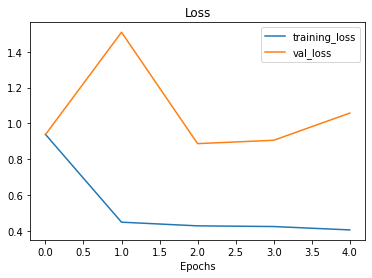

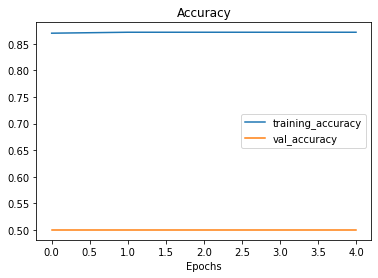

In [ ]:
plot_loss_curves(history_3)

In [ ]:
train_data_augmented_shuffled = train_datagen_augmented.flow_from_directory(train_dir,
                                                                            target_size=(224, 224),
                                                                            batch_size=32,
                                                                            class_mode='binary',
                                                                            shuffle=True) # Shuffle data (default)

Found 1123 images belonging to 2 classes.


In [ ]:
model_4 = Sequential([
  Conv2D(10, 3, activation='relu', input_shape=(224, 224, 3)),
  MaxPool2D(),
  Conv2D(10, 3, activation='relu'),
  MaxPool2D(),
  Conv2D(10, 3, activation='relu'),
  MaxPool2D(),
  Flatten(),
  Dense(1, activation='sigmoid')
])

# Compile the model
model_4.compile(loss='binary_crossentropy',
                optimizer=Adam(),
                metrics=['accuracy'])

# Fit the model
history_4 = model_4.fit(train_data_augmented_shuffled, # now the augmented data is shuffled
                        epochs=5,
                        steps_per_epoch=len(train_data_augmented_shuffled),
                        validation_data=test_data,
                        validation_steps=len(test_data))

Epoch 1/5
36/36 [==============================] - 29s 762ms/step - loss: 0.4126 - accuracy: 0.8504 - val_loss: 1.1619 - val_accuracy: 0.5000
Epoch 2/5
36/36 [==============================] - 28s 770ms/step - loss: 0.3836 - accuracy: 0.8718 - val_loss: 1.3722 - val_accuracy: 0.5000
Epoch 3/5
36/36 [==============================] - 27s 764ms/step - loss: 0.3864 - accuracy: 0.8718 - val_loss: 1.3534 - val_accuracy: 0.5000
Epoch 4/5
36/36 [==============================] - 27s 764ms/step - loss: 0.3815 - accuracy: 0.8718 - val_loss: 1.2130 - val_accuracy: 0.5000
Epoch 5/5
36/36 [==============================] - 29s 813ms/step - loss: 0.3771 - accuracy: 0.8718 - val_loss: 1.0719 - val_accuracy: 0.5000


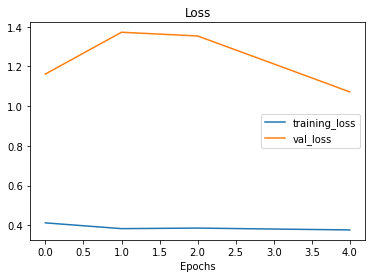

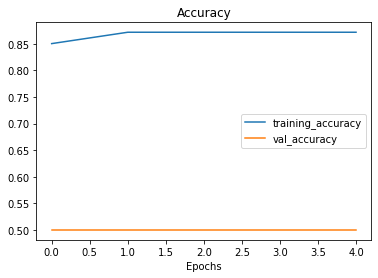

In [ ]:
plot_loss_curves(history_4)

In [ ]:
model_5 = Sequential([
  Conv2D(10, 3, activation='relu', input_shape=(224, 224, 3)), # same input shape as our images
  Conv2D(10, 3, activation='relu'),
  MaxPool2D(),
  Conv2D(10, 3, activation='relu'),
  Conv2D(10, 3, activation='relu'),
  MaxPool2D(),
  Flatten(),
  Dense(1, activation='sigmoid')
])

# Compile the model
model_5.compile(loss="binary_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

# Fit the model
history_5 = model_5.fit(train_data_augmented_shuffled,
                        epochs=5,
                        steps_per_epoch=len(train_data_augmented_shuffled),
                        validation_data=test_data,
                        validation_steps=len(test_data))

Epoch 1/5
36/36 [==============================] - 30s 769ms/step - loss: 0.4120 - accuracy: 0.8709 - val_loss: 0.9278 - val_accuracy: 0.5000
Epoch 2/5
36/36 [==============================] - 28s 765ms/step - loss: 0.4138 - accuracy: 0.8718 - val_loss: 0.9722 - val_accuracy: 0.5000
Epoch 3/5
36/36 [==============================] - 28s 779ms/step - loss: 0.3795 - accuracy: 0.8718 - val_loss: 1.0438 - val_accuracy: 0.5000
Epoch 4/5
36/36 [==============================] - 28s 772ms/step - loss: 0.3755 - accuracy: 0.8718 - val_loss: 1.1766 - val_accuracy: 0.5000
Epoch 5/5
36/36 [==============================] - 28s 774ms/step - loss: 0.3789 - accuracy: 0.8709 - val_loss: 1.1008 - val_accuracy: 0.5000


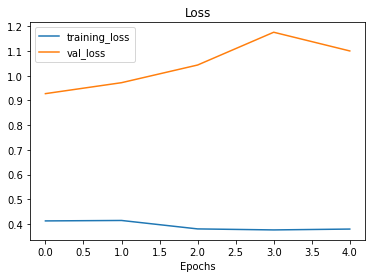

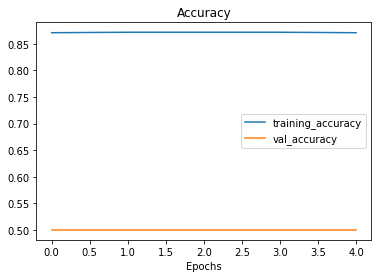

In [ ]:
plot_loss_curves(history_5)

In [ ]:
model_1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 222, 222, 10)      280       
                                                                 
 conv2d_1 (Conv2D)           (None, 220, 220, 10)      910       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 110, 110, 10)     0         
 )                                                               
                                                                 
 conv2d_2 (Conv2D)           (None, 108, 108, 10)      910       
                                                                 
 conv2d_3 (Conv2D)           (None, 106, 106, 10)      910       
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 53, 53, 10)       0         
 2D)                                                    

In [ ]:
model_5.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_13 (Conv2D)          (None, 222, 222, 10)      280       
                                                                 
 conv2d_14 (Conv2D)          (None, 220, 220, 10)      910       
                                                                 
 max_pooling2d_8 (MaxPooling  (None, 110, 110, 10)     0         
 2D)                                                             
                                                                 
 conv2d_15 (Conv2D)          (None, 108, 108, 10)      910       
                                                                 
 conv2d_16 (Conv2D)          (None, 106, 106, 10)      910       
                                                                 
 max_pooling2d_9 (MaxPooling  (None, 53, 53, 10)       0         
 2D)                                                  

In [ ]:
resnet_url = "https://tfhub.dev/google/imagenet/resnet_v2_50/feature_vector/4"

efficientnet_url = "https://tfhub.dev/tensorflow/efficientnet/b0/feature-vector/1"

In [ ]:
IMAGE_SHAPE = (224, 224)
BATCH_SIZE = 32

train_dir = "/content/drive/MyDrive/SheepData/Train/"
test_dir = "/content/drive/MyDrive/SheepData/Test/"

train_datagen = ImageDataGenerator(rescale=1/255.)
test_datagen = ImageDataGenerator(rescale=1/255.)

print("Training images:")
train_data = train_datagen.flow_from_directory(train_dir,
                                               target_size=IMAGE_SHAPE,
                                               batch_size=BATCH_SIZE,
                                               class_mode="binary")

print("Testing images:")
test_data = train_datagen.flow_from_directory(test_dir,
                                              target_size=IMAGE_SHAPE,
                                              batch_size=BATCH_SIZE,
                                              class_mode="binary")

Training images:
Found 1123 images belonging to 2 classes.
Testing images:
Found 20 images belonging to 2 classes.


In [ ]:
def create_model(model_url, num_classes=2):
  # Download the pretrained model and save it as a Keras layer
  feature_extractor_layer = hub.KerasLayer(model_url,
                                           trainable=False, # freeze the underlying patterns
                                           name='feature_extraction_layer',
                                           input_shape=IMAGE_SHAPE+(3,)) # define the input image shape
  
  # Create our own model
  model = tf.keras.Sequential([
    feature_extractor_layer, # use the feature extraction layer as the base
    layers.Dense(1, activation='sigmoid', name='output_layer') # create our own output layer      
  ])

  return model

In [ ]:
resnet_model = create_model(resnet_url, num_classes=train_data.num_classes)

# Compile
resnet_model.compile(loss='binary_crossentropy',
                     optimizer=tf.keras.optimizers.Adam(),
                     metrics=['accuracy'])

Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


In [ ]:
resnet_history = resnet_model.fit(train_data,
                                  epochs=5,
                                  steps_per_epoch=len(train_data),
                                  validation_data=test_data,
                                  validation_steps=len(test_data)) # name of log files

Epoch 1/5
36/36 [==============================] - 27s 557ms/step - loss: 0.3932 - accuracy: 0.8593 - val_loss: 0.7867 - val_accuracy: 0.5000
Epoch 2/5
36/36 [==============================] - 17s 467ms/step - loss: 0.2695 - accuracy: 0.8905 - val_loss: 0.5880 - val_accuracy: 0.7000
Epoch 3/5
36/36 [==============================] - 18s 499ms/step - loss: 0.2348 - accuracy: 0.9020 - val_loss: 0.7547 - val_accuracy: 0.6000
Epoch 4/5
36/36 [==============================] - 17s 467ms/step - loss: 0.2081 - accuracy: 0.9145 - val_loss: 0.6088 - val_accuracy: 0.7500
Epoch 5/5
36/36 [==============================] - 17s 461ms/step - loss: 0.1923 - accuracy: 0.9225 - val_loss: 0.6354 - val_accuracy: 0.7500
